In [1]:
import datetime
import sys
import time
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import os
import re
import matplotlib
import matplotlib.pyplot as plt
import eda_kernel
import lightgbm_with_simple_features
from sklearn.preprocessing import LabelEncoder
pd.set_option("display.min_rows", 20)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
path="data/"
application_train, application_test, bureau, bureau_balance, credit_card_balance, \
    installments_payments, POS_CASH_balance, previous_application, \
    HomeCredit_columns_description = \
    eda_kernel.load_all_tables(path)

Loading all the tables
Loaded 1 table.
Loaded 2 table.
Loaded 3 table.
Loaded 4 table.
Loaded 5 table.
Loaded 6 table.
Loaded 7 table.
Loaded 8 table.
Loaded 9 table.
Done.
Time Taken to load 9 tables 0:00:28.239583 secondes


In [3]:
application_train_save = application_train.copy()
application_test_save = application_test.copy()
bureau_save = bureau.copy()
bureau_balance_save = bureau_balance.copy()
credit_card_balance_save = credit_card_balance.copy()
installments_payments_save = installments_payments.copy()
POS_CASH_balance_save = POS_CASH_balance.copy()
previous_application_save = previous_application.copy()

# Feature engenering

- ["DAYS_EMPLOYED"]
- A partir du percentile 90, la valeur est 365243 jours donc 1000 ans
- NaN values for DAYS_EMPLOYED: 365.243 -> nan
- comparaison variables catégorielles
- valeurs aberrantes
- valeurs manquantes
- seuil de NaN toléré (<?)
- imputation des NaN des variables quantitatives par la médiane ( car bcp d'outliers)
- imputation des NaN des variables quantitatives par 0


# train set

In [9]:
application_train=lightgbm_with_simple_features.application_train()

In [10]:
application_train = application_train.drop(columns=['NAME_INCOME_TYPE_Maternity leave','NAME_INCOME_TYPE_Maternity leave', 'NAME_FAMILY_STATUS_Unknown'])

In [11]:
application_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 

# Corrélation

In [12]:
seuil = 0.9
corr = application_train.corr().abs()
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

C:\Users\tropical noise\AppData\Local\Temp\ipykernel_11788\495172189.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [13]:
# variables avec un coef de Pearson > 0.9
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables a supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

46 variables a supprimer :

AMT_GOODS_PRICE
REGION_RATING_CLIENT_W_CITY
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
OBS_60_CNT_SOCIAL_CIRCLE
NAME_CONTRACT_TYPE_Revolving loans
NAME_INCOME_TYPE_Pensioner
ORGANIZATION_TYPE_XNA
EMERGENCYSTATE_MODE_No
DAYS_EMPLOYED_PERC
INCOME_GOODS_DIFF
YEARS_BIRTH
CAR_EMPLOYED_DIFF
EXT_SOURCE_MUL
DEF_30_60_SUM
FLAGS_DOCUMENTS_VAR
FLAGS_DOCUMENTS_STD


In [14]:
# Suppression des variables fortement corrélées
print(f'application_train : {application_train.shape}')
application_train.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train : {application_train.shape}')

application_train : (307507, 264)
application_train : (307507, 218)


In [15]:
application_train

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATI

# test set

In [24]:
application_test=lightgbm_with_simple_features.application_test()

In [25]:
application_test.columns.tolist()

['SK_ID_CURR',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGA

In [26]:
# Suppression des variables fortement corrélées
print(f'application_test : {application_test.shape}')
application_test.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_test : {application_test.shape}')

application_test : (48744, 263)
application_test : (48744, 217)


In [27]:
application_test

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE

# credit_card_balance set

In [29]:
credit_card_balance=lightgbm_with_simple_features.credit_card_balance()

C:\Users\tropical noise\Notebook\P7\lightgbm_with_simple_features.py:426: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
seuil = 0.9
corr = credit_card_balance.corr().abs()
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

C:\Users\tropical noise\AppData\Local\Temp\ipykernel_11788\1208397339.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [31]:
# variables avec un coef de Pearson > 0.9
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables a supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

63 variables a supprimer :

CC_MONTHS_BALANCE_MEAN
CC_MONTHS_BALANCE_SUM
CC_MONTHS_BALANCE_VAR
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN
CC_AMT_DRAWINGS_OTHER_CURRENT_SUM
CC_AMT_INST_MIN_REGULARITY_MAX
CC_AMT_INST_MIN_REGULARITY_MEAN
CC_AMT_INST_MIN_REGULARITY_SUM
CC_AMT_INST_MIN_REGULARITY_VAR
CC_AMT_PAYMENT_CURRENT_SUM
CC_AMT_PAYMENT_TOTAL_CURRENT_MAX
CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN
CC_AMT_PAYMENT_TOTAL_CURRENT_SUM
CC_AMT_PAYMENT_TOTAL_CURRENT_VAR
CC_AMT_RECEIVABLE_PRINCIPAL_MIN
CC_AMT_RECEIVABLE_PRINCIPAL_MAX
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN
CC_AMT_RECEIVABLE_PRINCIPAL_SUM
CC_AMT_RECEIVABLE_PRINCIPAL_VAR
CC_AMT_RECIVABLE_MIN
CC_AMT_RECIVABLE_MAX
CC_AMT_RECIVABLE_MEAN
CC_AMT_RECIVABLE_SUM
CC_AMT_RECIVABLE_VAR
CC_AMT_TOTAL_RECEIVABLE_MIN
CC_AMT_TOTAL_RECEIVABLE_MAX
CC_AMT_TOTAL_RECEIVABLE_MEAN
CC_AMT_TOTAL_RECEIVABLE_SUM
CC_AMT_TOTAL_RECEIVABLE_VAR
CC_CNT_DRAWINGS_POS_CURRENT_MAX
CC_CNT_DRAWINGS_POS_CURRENT_MEAN
CC_CNT_DRAWINGS_POS_CURRENT_SUM
CC_CNT_DRAWINGS_POS_CURRENT_VAR
CC_CNT_INSTALMENT

In [32]:
# Suppression des variables fortement corrélées
print(f'application_train : {credit_card_balance.shape}')
credit_card_balance.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train : {credit_card_balance.shape}')

application_train : (103558, 151)
application_train : (103558, 88)


In [33]:
application_train = application_train.merge(credit_card_balance, on='SK_ID_CURR', how='left')

In [34]:
application_test = application_test.merge(credit_card_balance, on='SK_ID_CURR', how='left')

# installments_payments set

In [36]:
installments_payments=lightgbm_with_simple_features.installments_payments()

In [37]:
seuil = 0.9
corr = installments_payments.corr().abs()
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

C:\Users\tropical noise\AppData\Local\Temp\ipykernel_11788\326298473.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [38]:
# variables avec un coef de Pearson > 0.9
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables a supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

5 variables a supprimer :

INSTAL_PAYMENT_PERC_SUM
INSTAL_AMT_PAYMENT_MAX
INSTAL_AMT_PAYMENT_MEAN
INSTAL_AMT_PAYMENT_SUM
INSTAL_COUNT


In [39]:
# Suppression des variables fortement corrélées
print(f'application_train : {installments_payments.shape}')
installments_payments.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train : {installments_payments.shape}')

application_train : (339587, 26)
application_train : (339587, 21)


In [40]:
application_train = application_train.merge(installments_payments, on='SK_ID_CURR', how='left')

In [41]:
application_test = application_test.merge(installments_payments, on='SK_ID_CURR', how='left')

# POS_CASH_balance set

In [43]:
POS_CASH_balance=lightgbm_with_simple_features.pos_cash()

In [44]:
seuil = 0.9
corr = POS_CASH_balance.corr().abs()
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

C:\Users\tropical noise\AppData\Local\Temp\ipykernel_11788\1454885464.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [45]:
# variables avec un coef de Pearson > 0.9
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables a supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

3 variables a supprimer :

POS_SK_DPD_MEAN
POS_SK_DPD_DEF_MEAN
POS_COUNT


In [46]:
# Suppression des variables fortement corrélées
print(f'application_train : {POS_CASH_balance.shape}')
POS_CASH_balance.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train : {POS_CASH_balance.shape}')

application_train : (337252, 18)
application_train : (337252, 15)


In [47]:
application_train = application_train.merge(POS_CASH_balance, on='SK_ID_CURR', how='left')

In [48]:
application_test = application_test.merge(POS_CASH_balance, on='SK_ID_CURR', how='left')

# previous_application set

In [50]:
previous_application=previous_application.drop(columns=['RATE_INTEREST_PRIVILEGED', 'RATE_INTEREST_PRIMARY'])

In [54]:
previous_application=lightgbm_with_simple_features.previous_applications()

In [55]:
seuil = 0.9
corr = previous_application.corr().abs()
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

C:\Users\tropical noise\AppData\Local\Temp\ipykernel_11788\2823098083.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [56]:
# variables avec un coef de Pearson > 0.9
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables a supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

66 variables a supprimer :

PREV_AMT_CREDIT_MIN
PREV_AMT_CREDIT_MAX
PREV_AMT_CREDIT_MEAN
PREV_AMT_GOODS_PRICE_MAX
PREV_AMT_GOODS_PRICE_MEAN
PREV_AMT_DECLINED_MIN
PREV_AMT_DECLINED_MAX
PREV_AMT_DECLINED_MEAN
PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN
PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN
PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN
PREV_NAME_PAYMENT_TYPE_XNA_MEAN
PREV_CODE_REJECT_REASON_CLIENT_MEAN
PREV_CODE_REJECT_REASON_XAP_MEAN
PREV_NAME_GOODS_CATEGORY_XNA_MEAN
PREV_NAME_PORTFOLIO_Cards_MEAN
PREV_NAME_PORTFOLIO_POS_MEAN
PREV_CHANNEL_TYPE_Car dealer_MEAN
PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN
PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN
PREV_NAME_SELLER_INDUSTRY_XNA_MEAN
PREV_PRODUCT_COMBINATION_nan_MEAN
APPROVED_AMT_ANNUITY_MIN
APPROVED_AMT_ANNUITY_MAX
APPROVED_AMT_ANNUITY_MEAN
APPROVED_AMT_CREDIT_MIN
APPROVED_AMT_CREDIT_MAX
APPROVED_AMT_CREDIT_MEAN
APPROVED_APP_CREDIT_PERC_MIN
APPROVED_APP_CREDIT_PERC_MAX
APPROVED_APP_CREDIT_PERC_MEAN
APPROVED_AMT_DOWN_PAYMENT_MIN
APPROVED_AMT_DOWN_PAYMENT_MAX
APP

In [57]:
# Suppression des variables fortement corrélées
print(f'application_train : {previous_application.shape}')
previous_application.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train : {previous_application.shape}')

application_train : (338857, 285)
application_train : (338857, 219)


In [58]:
application_train = application_train.merge(previous_application, on='SK_ID_CURR', how='left')

In [59]:
application_test = application_test.merge(previous_application, on='SK_ID_CURR', how='left')

# bureau_balance set

In [60]:
bureau_balance=lightgbm_with_simple_features.bureau_and_balance()

In [64]:
seuil = 0.9
corr = bureau_balance.corr().abs()
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

C:\Users\tropical noise\AppData\Local\Temp\ipykernel_11788\387911875.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [65]:
# variables avec un coef de Pearson > 0.9
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables a supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

21 variables a supprimer :

BURO_AMT_CREDIT_SUM_DEBT_SUM
BURO_MONTHS_BALANCE_MAX_MAX
BURO_CREDIT_ACTIVE_Closed_MEAN
BURO_CREDIT_CURRENCY_currency 2_MEAN
ACTIVE_DAYS_CREDIT_ENDDATE_MAX
ACTIVE_CREDIT_DAY_OVERDUE_MAX
ACTIVE_AMT_CREDIT_SUM_SUM
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX
ACTIVE_AMT_CREDIT_SUM_DEBT_SUM
ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM
ACTIVE_AMT_ANNUITY_MEAN
ACTIVE_MONTHS_BALANCE_MAX_MAX
ACTIVE_MONTHS_BALANCE_SIZE_MEAN
CLOSED_DAYS_CREDIT_MIN
CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN
CLOSED_AMT_CREDIT_SUM_DEBT_SUM
CLOSED_AMT_ANNUITY_MAX
CLOSED_AMT_ANNUITY_MEAN
CLOSED_MONTHS_BALANCE_MAX_MAX
CLOSED_MONTHS_BALANCE_SIZE_MEAN
CLOSED_MONTHS_BALANCE_SIZE_SUM


In [66]:
# Suppression des variables fortement corrélées
print(f'application_train : {bureau_balance.shape}')
bureau_balance.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train : {bureau_balance.shape}')

application_train : (305811, 116)
application_train : (305811, 95)


In [67]:
application_train = application_train.merge(bureau_balance, on='SK_ID_CURR', how='left')

In [68]:
application_test = application_test.merge(bureau_balance, on='SK_ID_CURR', how='left')

In [69]:
train_set = eda_kernel.reduce_mem_usage(application_train, verbose=True)                                 
test_set = eda_kernel.reduce_mem_usage(application_test, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 1280.67 MB
Memory usage après optimization: 453.97 MB
Diminution de 64.6%
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Memory usage du dataframe: 202.63 MB
Memory usage après optimization: 71.08 MB
Diminution de 64.9%
-------------------------------------------------------------------------------


nombre de variable avec valeurs manquantes  478


C:\Users\tropical noise\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



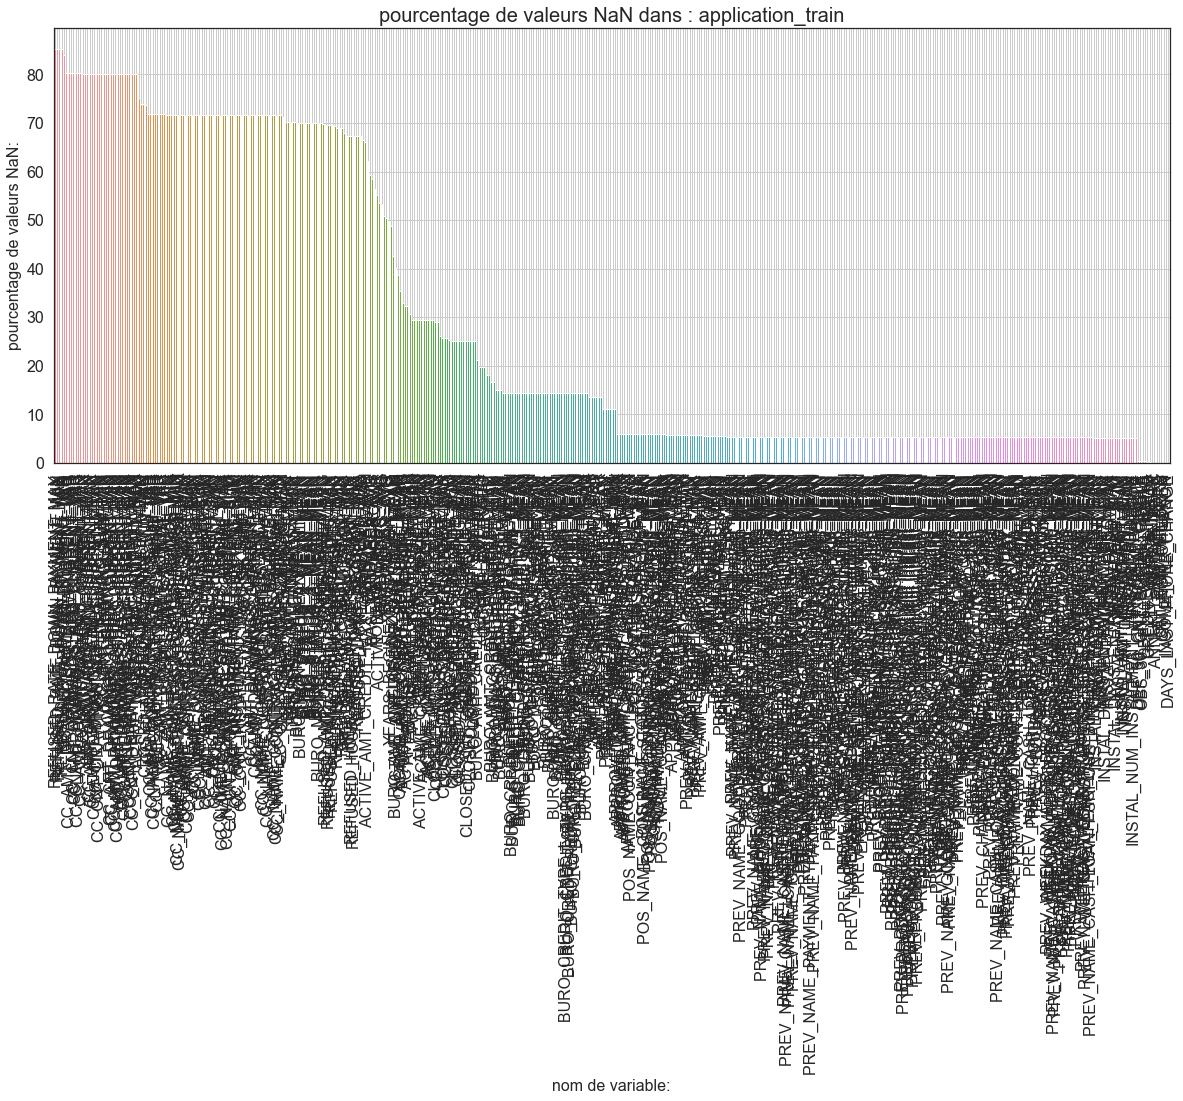

In [70]:
df_nan = eda_kernel.nan_df_create(train_set)
eda_kernel.plot_nan_percent(df_nan, 'application_train', grid=True)

nombre de variable avec valeurs manquantes  473


C:\Users\tropical noise\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



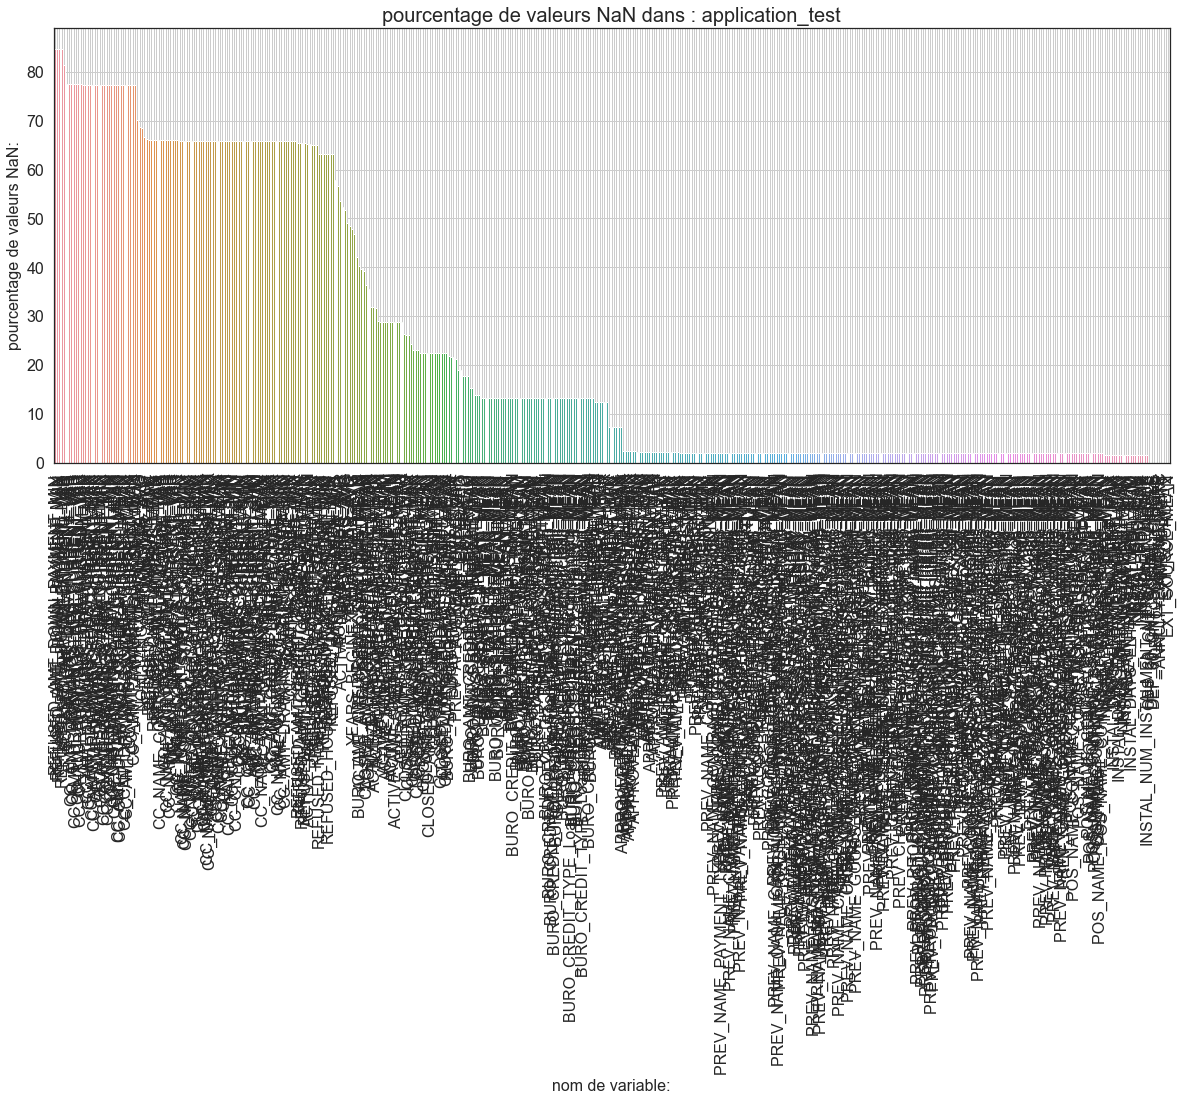

In [71]:
df_nan = eda_kernel.nan_df_create(test_set)
eda_kernel.plot_nan_percent(df_nan, 'application_test', grid=True)

In [ ]:
perc = 70
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
train_set = train_set.dropna(axis=1, 
                thresh=min_count)

In [ ]:
perc = 70
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
test_set = test_set.dropna(axis=1, 
                thresh=min_count)

In [72]:
train_set.shape

(307507, 656)

In [73]:
test_set.shape

(48744, 655)

In [74]:
import re
train_set = train_set.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [75]:
#modélisation
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Lorsque nous rencontrons des problèmes avec des classes déséquilibrées d'un classifieur binaire (nous verrons la précision n'est pas la meilleure métrique), nous choisirons donc l'AUC et score F1

In [76]:
train_set_labels = train_set['TARGET']
train_lgbm_ids = train_set['SK_ID_CURR']
test_lgbm_ids = test_set['SK_ID_CURR']
train_set_lgbm = train_set.drop(columns=['SK_ID_CURR'])
test_set_lgbm = test_set.drop(columns=['SK_ID_CURR'])

In [77]:
train_set_lgbm.shape

(307507, 655)

In [78]:
test_set_lgbm.shape

(48744, 654)

In [79]:
train_set_lgbm, test_set_lgbm = train_set_lgbm.align(test_set_lgbm, join='inner', axis=1)

In [80]:
#initialiser un tableau vide pour les features importance
feature_importances = np.zeros(train_set_lgbm.shape[1])

#creation du model avec hyperparametres
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [81]:
#entrainement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    #split en jeux d'entraînement et de validation
    train_sans_features, valid_sans_features, train_sans_y, valid_sans_y = \
        train_test_split(train_set_lgbm, train_set_labels,
                         test_size=0.25, random_state=i)

    #entrainement en utilisant early stopping
    model.fit(train_sans_features, train_sans_y,
              early_stopping_rounds=100,
              eval_set=[(valid_sans_features, valid_sans_y)],
              eval_metric='auc', verbose=200)

    #sauvegarde des features importances
    feature_importances += model.feature_importances_

C:\Users\tropical noise\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\tropical noise\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[200]	valid_0's auc: 0.788717	valid_0's binary_logloss: 0.504969


C:\Users\tropical noise\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\tropical noise\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[200]	valid_0's auc: 0.784826	valid_0's binary_logloss: 0.503953


In [82]:
feature_importances = feature_importances / 2
df_lightgbm = \
    pd.DataFrame({'feature': list(train_set_lgbm.columns),
                  'importance': feature_importances}) \
    .sort_values('importance', ascending=False)

df_lightgbm.head()

,feature,importance
134,PAYMENT_RATE,131.5
143,EXT_SOURCE_MEAN,102.5
9,DAYS_EMPLOYED,87.0
8,DAYS_BIRTH,81.5
135,CREDIT_GOODS_RATIO,62.5


In [83]:
# Exploration des variables avec zéro importance
zero_features = list(df_lightgbm[df_lightgbm['importance'] == 0.0]['feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

121 variables avec 0.0 importance :



['FLAG_EMP_PHONE',
 'BURO_STATUS_nan_MEAN_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MAX',
 'ORGANIZATION_TYPE_Culture',
 'CLOSED_CREDIT_DAY_OVERDUE_MAX',
 'ORGANIZATION_TYPE_Emergency',
 'FLAG_DOCUMENT_12',
 'FLAG_CONT_MOBILE',
 'ORGANIZATION_TYPE_Housing',
 'ORGANIZATION_TYPE_Insurance',
 'CLOSED_CREDIT_DAY_OVERDUE_MEAN',
 'NAME_TYPE_SUITE_Other_A',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_10',
 'FLAG_MOBIL',
 'BURO_CREDIT_DAY_OVERDUE_MEAN',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_14',
 'ORGANIZATION_TYPE_Cleaning',
 'WEEKDAY_APPR_PROCESS_START_FRIDAY',
 'OCCUPATION_TYPE_Secretaries',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_19',
 'BURO_CREDIT_ACTIVE_nan_MEAN',
 'BURO_CREDIT_CURRENCY_nan_MEAN',
 'FLAG_DOCUMENT_9',
 'NAME_FAMILY_STATUS_Widow',
 'FLAG_DOCUMENT_20',
 'BURO_CREDIT_TYPE_nan_MEAN',
 'ORGANIZATION_TYPE_Mobile',
 'FLAG_DOCUMENT_16',
 'ORGANIZATION_TYPE_Advertising',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Student',
 'FLAG_DOCUMENT_21',
 'BURO_STATUS_5_MEAN_MEAN',
 'NAME_INCOME_TYPE_Bu

In [84]:
train_set = train_set_lgbm.drop(columns = zero_features)
test_set = test_set_lgbm.drop(columns = zero_features)

print('Training shape: ', train_set.shape)
print('Testing shape: ', test_set.shape)

Training shape:  (307507, 379)
Testing shape:  (48744, 379)


In [85]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

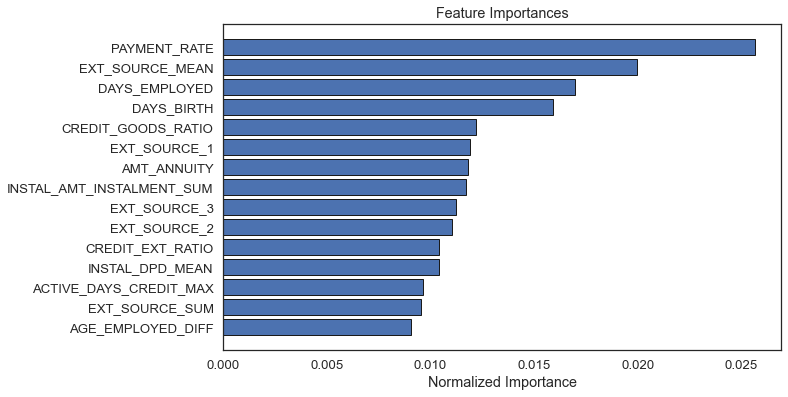

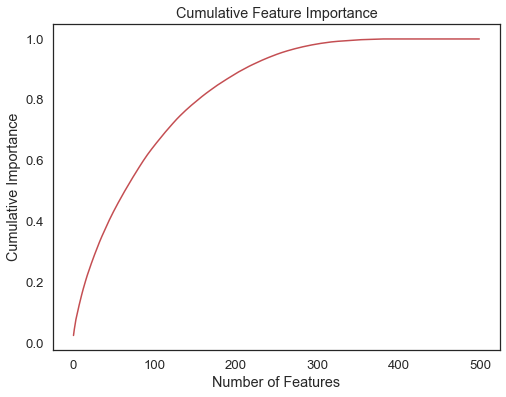

210 features required for 0.90 of cumulative importance


In [86]:
norm_feature_importances = plot_feature_importances(df_lightgbm)

In [87]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_set = train_set[features_to_keep]
test_set = test_set[features_to_keep]

train_set_exam = train_set[features_to_keep]
test_set_exam = test_set[features_to_keep]

In [88]:
train_set['TARGET'] = train_set_labels
train_set['SK_ID_CURR'] = train_lgbm_ids
test_set['SK_ID_CURR'] = test_lgbm_ids

train_set.to_csv('train_set.csv', index = False)
test_set.to_csv('test_set.csv', index = False)

In [89]:
train_set

,PAYMENT_RATE,EXT_SOURCE_MEAN,DAYS_EMPLOYED,DAYS_BIRTH,CREDIT_GOODS_RATIO,EXT_SOURCE_1,AMT_ANNUITY,INSTAL_AMT_INSTALMENT_SUM,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_EXT_RATIO,INSTAL_DPD_MEAN,ACTIVE_DAYS_CREDIT_MAX,EXT_SOURCE_SUM,AGE_EMPLOYED_DIFF,POS_MONTHS_BALANCE_SIZE,OWN_CAR_AGE,DAYS_ID_PUBLISH,INSTAL_DAYS_ENTRY_PAYMENT_MAX,CLOSED_DAYS_CREDIT_MAX,REGION_POPULATION_RELATIVE,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,INSTAL_PAYMENT_PERC_MEAN,APPROVED_AMT_INTEREST_MAX,PREV_AMT_ANNUITY_MEAN,ANNUITY_INCOME_PERC,APPROVED_CNT_PAYMENT_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,DEF_60_CREDIT_RATIO,INSTAL_AMT_PAYMENT_MIN,CREDIT_AGE_RATIO,BURO_AMT_CREDIT_SUM_DEBT_MEAN,INSTAL_DBD_SUM,INCOME_EXT_RATIO,BURO_DAYS_CREDIT_ENDDATE_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,INSTAL_DBD_MEAN,PREV_CNT_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_CREDIT_GOODS_RATIO_MEAN,DAYS_REGISTRATION,PREV_DAYS_DECISION_MIN,INCOME_CREDIT_PERC,INSTAL_PAYMENT_DIFF_MEAN,DAYS_LAST_PHONE_CHANGE,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,INSTAL_AMT_INSTALMENT_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_VAR,PREV_AMT_INTEREST_MAX,CODE_GENDER,ACTIVE_AMT_CREDIT_SUM_MAX,POS_NAME_CONTRACT_STATUS_Active_MEAN,APPROVED_AMT_CREDIT_GOODS_DIFF_MIN,PREV_AMT_ANNUITY_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_DAYS_DECISION_MAX,PREV_AMT_CREDIT_GOODS_RATIO_MAX,BURO_DAYS_CREDIT_UPDATE_MEAN,PREV_APP_CREDIT_PERC_VAR,ACTIVE_DAYS_CREDIT_MEAN,APARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG,INSTAL_AMT_INSTALMENT_MEAN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,INSTAL_DBD_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,BURO_DAYS_CREDIT_MAX,AMT_CREDIT,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,INSTAL_PAYMENT_DIFF_SUM,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,APPROVED_DAYS_DECISION_MAX,BURO_DAYS_CREDIT_VAR,POS_MONTHS_BALANCE_MEAN,PREV_AMT_ANNUITY_MIN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_DAYS_CREDIT_MEAN,APPROVED_AMT_INTEREST_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,INCOME_PER_PERSON,POS_MONTHS_BALANCE_MAX,FLAGS_DOCUMENTS_AVG,CLOSED_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_SUM,PREV_AMT_INTEREST_MEAN,PREV_AMT_CREDIT_GOODS_DIFF_MIN,BURO_AMT_CREDIT_SUM_MAX,APPROVED_AMT_CREDIT_GOODS_RATIO_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,BASEMENTAREA_AVG,NAME_FAMILY_STATUS_Married,REFUSED_DAYS_DECISION_MAX,PREV_NAME_YIELD_GROUP_low_action_MEAN,APPROVED_AMT_CREDIT_GOODS_RATIO_MAX,POS_SK_DPD_DEF_MAX,APARTMENTS_SUM_MEDI,APPROVED_AMT_APPLICATION_MAX,APPROVED_APP_CREDIT_PERC_VAR,PREV_DAYS_DECISION_MEAN,REFUSED_DAYS_DECISION_MIN,ACTIVE_DAYS_CREDIT_VAR,PREV_APP_CREDIT_PERC_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ACTIVE_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_ENDDATE_MIN,PREV_AMT_GOODS_PRICE_MIN,APPROVED_CNT_PAYMENT_SUM,BURO_CREDIT_TYPE_Mortgage_MEAN,NONLIVINGAREA_AVG,BURO_DAYS_CREDIT_MIN,BURO_CREDIT_TYPE_Microloan_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,CC_AMT_BALANCE_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_CREDIT_GOODS_DIFF_MAX,PREV_NAME_YIELD_GROUP_high_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_AMT_CREDIT_SUM_MEAN,BURO_STATUS_0_MEAN_MEAN,INSTAL_PAYMENT_DIFF_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,COMMONAREA_AVG,AMT_INCOME_TOTAL,PREV_AMT_APPLICATION_MEAN,PREV_AMT_DOWN_PAYMENT_MEAN,LANDAREA_AVG,CC_CNT_DRAWINGS_CURRENT_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,PREV_AMT_CREDIT_GOODS_DIFF_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,HOUR_APPR_PROCESS_START,PREV_AMT_CREDIT_GOODS_DIFF_MAX,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_AMT_APPLICATION_MAX,CLOSED_DAYS_CREDIT_MEAN,ACTIVE_AMT_ANNUITY_MAX,PREV_RATE_DOWN_PAYMENT_MAX,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MAX,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,BURO_STATUS_X_MEAN_MEAN,APPROVED_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_AMT_INTEREST_MIN,REFUSED_AMT_INTEREST_MAX,CC_AMT_DRAWINGS_POS_CURRE

In [90]:
test_set

,PAYMENT_RATE,EXT_SOURCE_MEAN,DAYS_EMPLOYED,DAYS_BIRTH,CREDIT_GOODS_RATIO,EXT_SOURCE_1,AMT_ANNUITY,INSTAL_AMT_INSTALMENT_SUM,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_EXT_RATIO,INSTAL_DPD_MEAN,ACTIVE_DAYS_CREDIT_MAX,EXT_SOURCE_SUM,AGE_EMPLOYED_DIFF,POS_MONTHS_BALANCE_SIZE,OWN_CAR_AGE,DAYS_ID_PUBLISH,INSTAL_DAYS_ENTRY_PAYMENT_MAX,CLOSED_DAYS_CREDIT_MAX,REGION_POPULATION_RELATIVE,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,INSTAL_PAYMENT_PERC_MEAN,APPROVED_AMT_INTEREST_MAX,PREV_AMT_ANNUITY_MEAN,ANNUITY_INCOME_PERC,APPROVED_CNT_PAYMENT_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,DEF_60_CREDIT_RATIO,INSTAL_AMT_PAYMENT_MIN,CREDIT_AGE_RATIO,BURO_AMT_CREDIT_SUM_DEBT_MEAN,INSTAL_DBD_SUM,INCOME_EXT_RATIO,BURO_DAYS_CREDIT_ENDDATE_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,INSTAL_DBD_MEAN,PREV_CNT_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_CREDIT_GOODS_RATIO_MEAN,DAYS_REGISTRATION,PREV_DAYS_DECISION_MIN,INCOME_CREDIT_PERC,INSTAL_PAYMENT_DIFF_MEAN,DAYS_LAST_PHONE_CHANGE,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,INSTAL_AMT_INSTALMENT_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_VAR,PREV_AMT_INTEREST_MAX,CODE_GENDER,ACTIVE_AMT_CREDIT_SUM_MAX,POS_NAME_CONTRACT_STATUS_Active_MEAN,APPROVED_AMT_CREDIT_GOODS_DIFF_MIN,PREV_AMT_ANNUITY_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_DAYS_DECISION_MAX,PREV_AMT_CREDIT_GOODS_RATIO_MAX,BURO_DAYS_CREDIT_UPDATE_MEAN,PREV_APP_CREDIT_PERC_VAR,ACTIVE_DAYS_CREDIT_MEAN,APARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG,INSTAL_AMT_INSTALMENT_MEAN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,INSTAL_DBD_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,BURO_DAYS_CREDIT_MAX,AMT_CREDIT,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,INSTAL_PAYMENT_DIFF_SUM,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,APPROVED_DAYS_DECISION_MAX,BURO_DAYS_CREDIT_VAR,POS_MONTHS_BALANCE_MEAN,PREV_AMT_ANNUITY_MIN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_DAYS_CREDIT_MEAN,APPROVED_AMT_INTEREST_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,INCOME_PER_PERSON,POS_MONTHS_BALANCE_MAX,FLAGS_DOCUMENTS_AVG,CLOSED_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_SUM,PREV_AMT_INTEREST_MEAN,PREV_AMT_CREDIT_GOODS_DIFF_MIN,BURO_AMT_CREDIT_SUM_MAX,APPROVED_AMT_CREDIT_GOODS_RATIO_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,BASEMENTAREA_AVG,NAME_FAMILY_STATUS_Married,REFUSED_DAYS_DECISION_MAX,PREV_NAME_YIELD_GROUP_low_action_MEAN,APPROVED_AMT_CREDIT_GOODS_RATIO_MAX,POS_SK_DPD_DEF_MAX,APARTMENTS_SUM_MEDI,APPROVED_AMT_APPLICATION_MAX,APPROVED_APP_CREDIT_PERC_VAR,PREV_DAYS_DECISION_MEAN,REFUSED_DAYS_DECISION_MIN,ACTIVE_DAYS_CREDIT_VAR,PREV_APP_CREDIT_PERC_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,ACTIVE_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_ENDDATE_MIN,PREV_AMT_GOODS_PRICE_MIN,APPROVED_CNT_PAYMENT_SUM,BURO_CREDIT_TYPE_Mortgage_MEAN,NONLIVINGAREA_AVG,BURO_DAYS_CREDIT_MIN,BURO_CREDIT_TYPE_Microloan_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,APPROVED_AMT_APPLICATION_MEAN,PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,CC_AMT_BALANCE_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_CREDIT_GOODS_DIFF_MAX,PREV_NAME_YIELD_GROUP_high_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_AMT_CREDIT_SUM_MEAN,BURO_STATUS_0_MEAN_MEAN,INSTAL_PAYMENT_DIFF_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,COMMONAREA_AVG,AMT_INCOME_TOTAL,PREV_AMT_APPLICATION_MEAN,PREV_AMT_DOWN_PAYMENT_MEAN,LANDAREA_AVG,CC_CNT_DRAWINGS_CURRENT_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,PREV_AMT_CREDIT_GOODS_DIFF_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,HOUR_APPR_PROCESS_START,PREV_AMT_CREDIT_GOODS_DIFF_MAX,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_AMT_APPLICATION_MAX,CLOSED_DAYS_CREDIT_MEAN,ACTIVE_AMT_ANNUITY_MAX,PREV_RATE_DOWN_PAYMENT_MAX,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MAX,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,BURO_STATUS_X_MEAN_MEAN,APPROVED_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_AMT_INTEREST_MIN,REFUSED_AMT_INTEREST_MAX,CC_AMT_DRAWINGS_POS_CURRE

In [91]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [92]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train_set_exam, train_set_labels)

C:\Users\tropical noise\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\tropical noise\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[200]	valid_0's auc: 0.789642	valid_0's binary_logloss: 0.503618


C:\Users\tropical noise\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\tropical noise\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[200]	valid_0's auc: 0.783468	valid_0's binary_logloss: 0.504229

There are 0 features with 0.0 importance


In [93]:
feature_importances.shape

(251, 2)

In [94]:
feature_importances.head()

,feature,importance
0,PAYMENT_RATE,142.0
1,EXT_SOURCE_MEAN,131.0
2,DAYS_EMPLOYED,102.0
3,DAYS_BIRTH,80.5
5,EXT_SOURCE_1,78.0


In [95]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 0 features with 0.0 importance


,feature,importance
216,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,5.0
243,ELEVATORS_AVG,4.5
206,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,4.5
245,REFUSED_HOUR_APPR_PROCESS_START_MAX,4.0
247,DEF_30_CNT_SOCIAL_CIRCLE,4.0


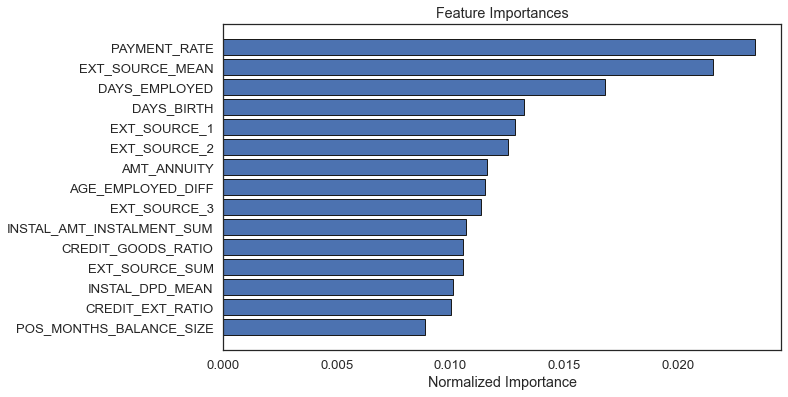

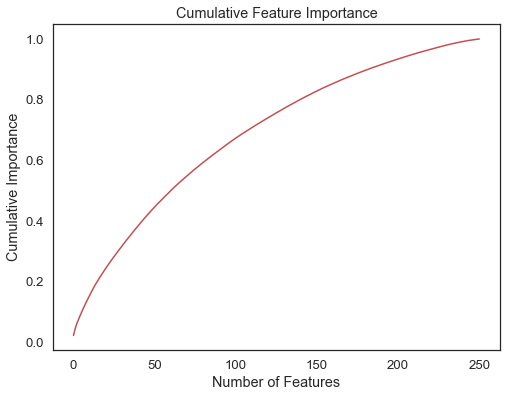

183 features required for 0.90 of cumulative importance


In [96]:
norm_feature_importances = plot_feature_importances(feature_importances)